#### Library Imports

In [2]:
# Core Libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data & Synthesis
import kagglehub
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

# Preprocessing & Modeling
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Evaluation
from sklearn.metrics import (
    accuracy_score, f1_score, ConfusionMatrixDisplay, roc_curve, auc
)

warnings.filterwarnings("ignore")


c:\Users\tanib\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problem
#### Goal:
Build a health risk calculating pipeline using wearable-derived metrics (steps, activity, heart rate, sleep, BMI, sedentary time) and simulated demographics (age, sex, smoking, children) to create realistic user profiles for insurance-style risk analysis.

#### Target variables:
- FinalRiskScore: a continuous composite risk index.
- KMeansTier: a 3-class risk tier label (Gold/Low, Silver/Medium, Bronze/High) derived from clustering on health metrics and risk score.

#### Task: 
Multiclass classification of users into risk tiers using health features.

#### Success metrics:
- Predictive: Accuracy and F1-weighted for tier classification.
- Structural: Reasonable cluster separation (silhouette score), stable tiers across KMeans runs.

#### Constraints:
- No real claims/mortality labels; tiers are unsupervised and risk scores are proxy outcomes.
- Original dataset is small (33 users); synthetic expansion to 1033 is used for modeling.

#### Setting up DF

In [3]:
# Loading Data ---
path = kagglehub.dataset_download("arashnic/fitbit")
data_path = os.path.join(path, "mturkfitbit_export_4.12.16-5.12.16", "Fitabase Data 4.12.16-5.12.16")
daily_df = pd.read_csv(os.path.join(data_path, "dailyActivity_merged.csv"))
heart_df = pd.read_csv(os.path.join(data_path, "heartrate_seconds_merged.csv"))
sleep_df = pd.read_csv(os.path.join(data_path, "minuteSleep_merged.csv"))
weight_df = pd.read_csv(os.path.join(data_path, "weightLogInfo_merged.csv"))
daily_df

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.500000,8.500000,0.0,1.88,0.55,6.06,0.00,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.970000,6.970000,0.0,1.57,0.69,4.71,0.00,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.740000,6.740000,0.0,2.44,0.40,3.91,0.00,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.280000,6.280000,0.0,2.14,1.26,2.83,0.00,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.160000,8.160000,0.0,2.71,0.41,5.04,0.00,36,10,221,773,1863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,8877689391,5/8/2016,10686,8.110000,8.110000,0.0,1.08,0.20,6.80,0.00,17,4,245,1174,2847
936,8877689391,5/9/2016,20226,18.250000,18.250000,0.0,11.10,0.80,6.24,0.05,73,19,217,1131,3710
937,8877689391,5/10/2016,10733,8.150000,8.150000,0.0,1.35,0.46,6.28,0.00,18,11,224,1187,2832
938,8877689391,5/11/2016,21420,19.559999,19.559999,0.0,13.22,0.41,5.89,0.00,88,12,213,1127,3832


Doing basic operations to format data

In [4]:
daily_df['Date'] = pd.to_datetime(daily_df['ActivityDate']).dt.date

In [5]:
heart_df['Date'] = pd.to_datetime(heart_df['Time']).dt.date
heart_daily = heart_df.groupby(['Id', 'Date'])['Value'].mean().reset_index()
heart_daily.rename(columns={'Value': 'AvgHeartRate'}, inplace=True)

In [6]:
sleep_df['Date'] = pd.to_datetime(sleep_df['date']).dt.date
sleep_daily = sleep_df.groupby(['Id', 'Date'])['value'].count().reset_index()
sleep_daily.rename(columns={'value': 'TotalMinutesAsleep'}, inplace=True)

In [7]:
weight_df['Date'] = pd.to_datetime(weight_df['Date']).dt.date
weight_daily = weight_df.groupby(['Id', 'Date'])['BMI'].mean().reset_index()

In [8]:
df_final = daily_df.merge(heart_daily, on=['Id', 'Date'], how='left')
df_final = df_final.merge(sleep_daily, on=['Id', 'Date'], how='left')
df_final = df_final.merge(weight_daily, on=['Id', 'Date'], how='left')

print(f"Merged Shape: {df_final.shape}")

Merged Shape: (940, 19)


#### Initial Data

In [9]:
df_final

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Date,AvgHeartRate,TotalMinutesAsleep,BMI
0,1503960366,4/12/2016,13162,8.500000,8.500000,0.0,1.88,0.55,6.06,0.00,25,13,328,728,1985,2016-04-12,NaN,346.0,NaN
1,1503960366,4/13/2016,10735,6.970000,6.970000,0.0,1.57,0.69,4.71,0.00,21,19,217,776,1797,2016-04-13,NaN,407.0,NaN
2,1503960366,4/14/2016,10460,6.740000,6.740000,0.0,2.44,0.40,3.91,0.00,30,11,181,1218,1776,2016-04-14,NaN,NaN,NaN
3,1503960366,4/15/2016,9762,6.280000,6.280000,0.0,2.14,1.26,2.83,0.00,29,34,209,726,1745,2016-04-15,NaN,442.0,NaN
4,1503960366,4/16/2016,12669,8.160000,8.160000,0.0,2.71,0.41,5.04,0.00,36,10,221,773,1863,2016-04-16,NaN,400.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,8877689391,5/8/2016,10686,8.110000,8.110000,0.0,1.08,0.20,6.80,0.00,17,4,245,1174,2847,2016-05-08,72.550523,NaN,25.559999
936,8877689391,5/9/2016,20226,18.250000,18.250000,0.0,11.10,0.80,6.24,0.05,73,19,217,1131,3710,2016-05-09,89.615738,NaN,25.610001
937,8877689391,5/10/2016,10733,8.150000,8.150000,0.0,1.35,0.46,6.28,0.00,18,11,224,1187,2832,2016-05-10,71.544377,NaN,NaN
938,8877689391,5/11/2016,21420,19.559999,19.559999,0.0,13.22,0.41,5.89,0.00,88,12,213,1127,3832,2016-05-11,89.149122,NaN,25.559999


In [10]:
user_data = df_final.groupby('Id').agg({
    'TotalSteps': ['mean', 'std'],
    'TotalDistance': 'mean',
    'Calories': 'mean',
    'VeryActiveMinutes': 'mean',
    'FairlyActiveMinutes': 'mean',
    'LightlyActiveMinutes': 'mean',
    'SedentaryMinutes': 'mean',
    'AvgHeartRate': 'mean',
    'TotalMinutesAsleep': 'mean',
    'BMI': 'mean'
}).reset_index()

# Flatten column names
user_data.columns = ['UserId', 'AvgSteps', 'StdSteps', 'AvgDistance', 'AvgCalories',
                     'AvgVeryActive', 'AvgFairlyActive', 'AvgLightlyActive', 
                     'AvgSedentary', 'AvgHeartRate', 'AvgSleepMinutes', 'AvgBMI']

# Convert sleep to hours
user_data['AvgSleepHours'] = user_data['AvgSleepMinutes'] / 60

print(f"\nMissing values BEFORE imputation:")
user_data.isna().sum()


Missing values BEFORE imputation:


UserId               0
AvgSteps             0
StdSteps             0
AvgDistance          0
AvgCalories          0
AvgVeryActive        0
AvgFairlyActive      0
AvgLightlyActive     0
AvgSedentary         0
AvgHeartRate        19
AvgSleepMinutes      9
AvgBMI              25
AvgSleepHours        9
dtype: int64

#### Filling Missing Values

In [11]:
np.random.seed(42)  # For reproducibility

# --- HEART RATE IMPUTATION ---
# Research: Activity level inversely correlates with resting HR (r = -0.3 to -0.5)
# But 20% of active people have HIGH HR (overtraining, genetics, stress)

def impute_heart_rate_scientific(row):
    """
    Imputing heart rate based on activity with realistic variance
    """
    if pd.notna(row['AvgHeartRate']):
        return row['AvgHeartRate']  # Keep real data
    
    steps = row['AvgSteps']
    very_active = row['AvgVeryActive']
    
    # Base calculation: Inverse relationship with activity
    # Formula: HR = 85 - 0.0015*steps + noise
    base_hr = 85 - (steps / 1000) * 1.5
    
    # Add variance based on activity intensity
    if very_active > 30:
        # High intensity exercisers
        dice_roll = np.random.random()
        if dice_roll < 0.70:
            # 70%: Healthy athlete (low HR)
            hr = np.random.normal(60, 8)  # Mean 60, std 8
        elif dice_roll < 0.90:
            # 20%: Overtraining or high genetic baseline
            hr = np.random.normal(80, 10)  # Elevated despite fitness
        else:
            # 10%: Extreme - potential cardiac stress
            hr = np.random.normal(95, 8)  # High risk
    
    elif very_active > 10:
        # Moderate exercisers
        hr = np.random.normal(base_hr, 10)
    
    else:
        # Sedentary
        dice_roll = np.random.random()
        if dice_roll < 0.70:
            # 70%: Expected high HR
            hr = np.random.normal(80, 12)
        else:
            # 30%: Naturally healthy despite inactivity
            hr = np.random.normal(68, 10)
    
    # Realistic bounds (50-110 bpm resting)
    return np.clip(hr, 50, 110)


# --- SLEEP IMPUTATION ---
# Research: Activity improves sleep BUT overtraining/stress disrupts it
# 25-30% of athletes have poor sleep despite activity

def impute_sleep_scientific(row):
    """
    Imputing sleep based on activity with realistic stress/overtraining scenarios
    """
    if pd.notna(row['AvgSleepHours']):
        return row['AvgSleepHours']
    
    steps = row['AvgSteps']
    very_active = row['AvgVeryActive']
    sedentary = row['AvgSedentary']
    
    if very_active > 40:
        # High intensity exercisers
        dice_roll = np.random.random()
        if dice_roll < 0.60:
            # 60%: Good sleep (benefits of exercise)
            sleep = np.random.normal(7.5, 0.8)
        elif dice_roll < 0.85:
            # 25%: Poor sleep (overtraining, stress, busy lifestyle)
            sleep = np.random.normal(5.5, 1.0)  # Sleep deprivation
        else:
            # 15%: Excessive sleep (overtraining recovery or depression)
            sleep = np.random.normal(9.5, 1.0)
    
    elif steps > 7500:
        # Moderately active
        dice_roll = np.random.random()
        if dice_roll < 0.70:
            # 70%: Normal to good sleep
            sleep = np.random.normal(7.2, 1.0)
        else:
            # 30%: Poor sleep (stress unrelated to exercise)
            sleep = np.random.normal(6.0, 1.2)
    
    else:
        # Sedentary
        dice_roll = np.random.random()
        if dice_roll < 0.50:
            # 50%: Poor sleep (unhealthy lifestyle)
            sleep = np.random.normal(6.0, 1.5)
        elif dice_roll < 0.80:
            # 30%: Normal sleep
            sleep = np.random.normal(7.0, 1.0)
        else:
            # 20%: Excessive sleep (sedentary lifestyle)
            sleep = np.random.normal(9.0, 1.5)
    
    # Realistic bounds (4-12 hours)
    return np.clip(sleep, 4, 12)


# --- BMI IMPUTATION ---
# Research: "Metabolically Healthy Obese" - 10-47% of obese are fit
# Exercise doesn't guarantee weight loss (Exercise Paradox)

def impute_bmi_scientific(row):
    """
    Imputing BMI with realistic "fit but fat" and "thin but sedentary" scenarios
    """
    if pd.notna(row['AvgBMI']):
        return row['AvgBMI']
    
    steps = row['AvgSteps']
    calories = row['AvgCalories']
    very_active = row['AvgVeryActive']
    
    # Base BMI calculation (inverse with activity)
    base_bmi = 30 - (steps / 1000) * 0.6
    
    if very_active > 30:
        # High exercisers
        dice_roll = np.random.random()
        if dice_roll < 0.60:
            # 60%: Normal BMI (fitness pays off)
            bmi = np.random.normal(23, 2.5)
        elif dice_roll < 0.85:
            # 25%: Overweight despite exercise (diet, genetics)
            bmi = np.random.normal(27, 2.0)  # "Fit but chubby"
        else:
            # 15%: Obese but metabolically healthy (MHO phenotype)
            bmi = np.random.normal(32, 3.0)
    
    elif steps > 7500:
        # Moderately active
        dice_roll = np.random.random()
        if dice_roll < 0.50:
            # 50%: Normal to slightly overweight
            bmi = np.random.normal(25, 3.0)
        else:
            # 50%: Overweight (insufficient activity for weight loss)
            bmi = np.random.normal(28, 3.5)
    
    else:
        # Sedentary
        dice_roll = np.random.random()
        if dice_roll < 0.25:
            # 25%: Normal BMI (genetics, diet, young age)
            bmi = np.random.normal(23, 2.0)
        elif dice_roll < 0.55:
            # 30%: Overweight
            bmi = np.random.normal(28, 2.5)
        else:
            # 45%: Obese (expected for sedentary)
            bmi = np.random.normal(33, 4.0)
    
    # Realistic bounds (18-45 BMI)
    return np.clip(bmi, 18, 45)


# Apply imputation functions
user_data['AvgHeartRate'] = user_data.apply(impute_heart_rate_scientific, axis=1)
user_data['AvgSleepHours'] = user_data.apply(impute_sleep_scientific, axis=1)
user_data['AvgBMI'] = user_data.apply(impute_bmi_scientific, axis=1)
pre_final = user_data.drop('AvgSleepMinutes',axis = 1)
print(pre_final.isnull().sum())
pre_final

UserId              0
AvgSteps            0
StdSteps            0
AvgDistance         0
AvgCalories         0
AvgVeryActive       0
AvgFairlyActive     0
AvgLightlyActive    0
AvgSedentary        0
AvgHeartRate        0
AvgBMI              0
AvgSleepHours       0
dtype: int64


,UserId,AvgSteps,StdSteps,AvgDistance,AvgCalories,AvgVeryActive,AvgFairlyActive,AvgLightlyActive,AvgSedentary,AvgHeartRate,AvgBMI,AvgSleepHours
0,1503960366,12116.741935,3052.484201,7.809677,1816.419355,38.709677,19.161290,219.935484,848.161290,51.104959,22.650000,6.386667
1,1624580081,5743.903226,6177.048612,3.914839,1483.354839,8.677419,5.806452,153.483871,1257.741935,83.826826,28.810210,4.168735
2,1644430081,7282.966667,4325.478825,5.295333,2811.300000,9.566667,21.366667,178.466667,1161.866667,83.348496,22.229835,4.613333
3,1844505072,2580.064516,2712.836854,1.706129,1573.483871,0.129032,1.290323,115.451613,1206.612903,78.105153,30.292312,9.610000
4,1927972279,916.129032,1205.269064,0.634516,2172.806452,1.322581,0.774194,38.580645,1317.419355,73.029462,47.540001,4.916667
5,2022484408,11370.645161,2806.994710,8.084193,2509.967742,36.290323,19.354839,257.451613,1112.580645,80.060777,24.529191,5.871814
6,2026352035,5566.870968,2977.834815,3.454839,1540.645161,0.096774,0.258065,256.645161,689.419355,87.632634,37.123998,7.990323
7,2320127002,4716.870968,2254.614642,3.187742,1724.161290,1.354839,2.580645,198.193548,1220.096774,73.697962,36.725120,1.150000
8,2347167796,9519.666667,4682.093700,6.355556,2043.444444,13.500000,20.555556,252.500000,687.166667,76.352558,22.482347,6.824074
9,2873212765,7555.774194,1514.471585,5.101613,1916.967742,14.096774,6.129032,308.000000,1097.193548,76.085961,21.570001,6.236233


In [12]:
print(f"Original data loaded: {pre_final.shape}")
print(f"Total users: {len(pre_final)}")

Original data loaded: (33, 12)
Total users: 33


Visualizing a bit

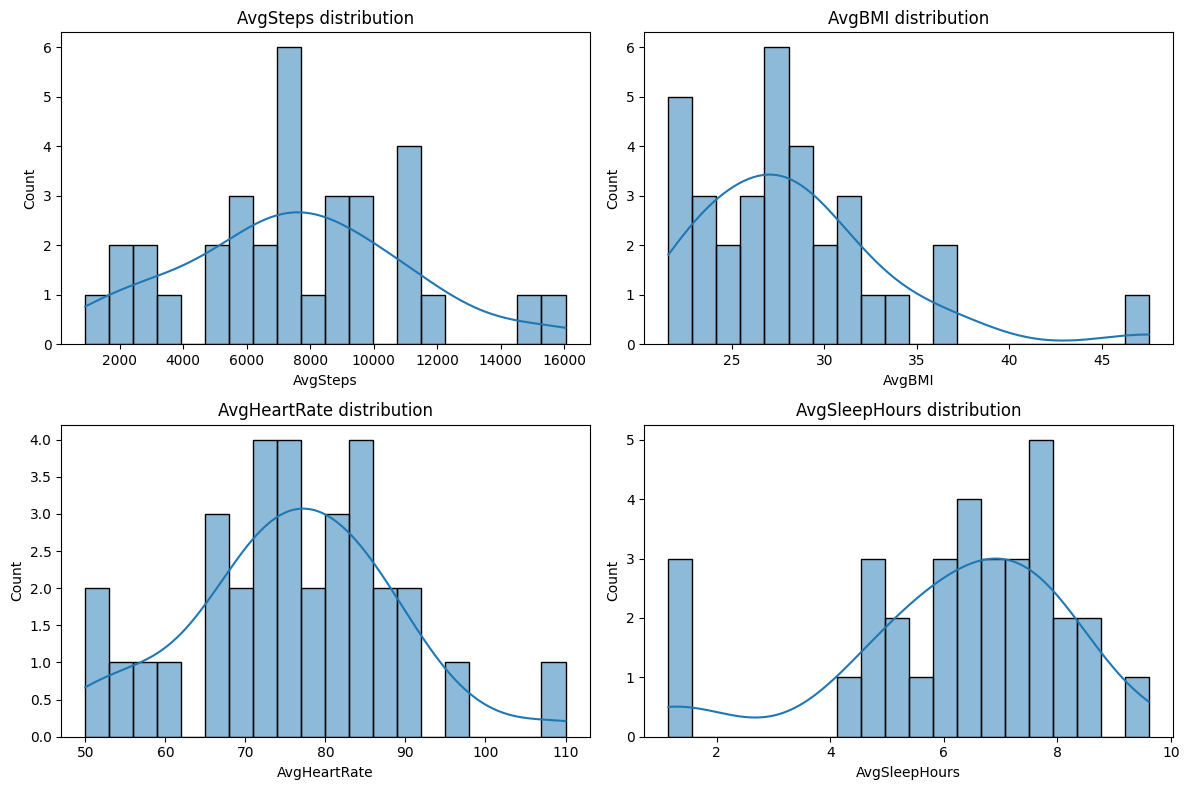

In [13]:
eda_cols = ['AvgSteps', 'AvgBMI', 'AvgHeartRate', 'AvgSleepHours']

plt.figure(figsize=(12, 8))
for i, col in enumerate(eda_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(pre_final[col], kde=True, bins=20)
    plt.title(f'{col} distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


Lets get some correlations between columns that we require further

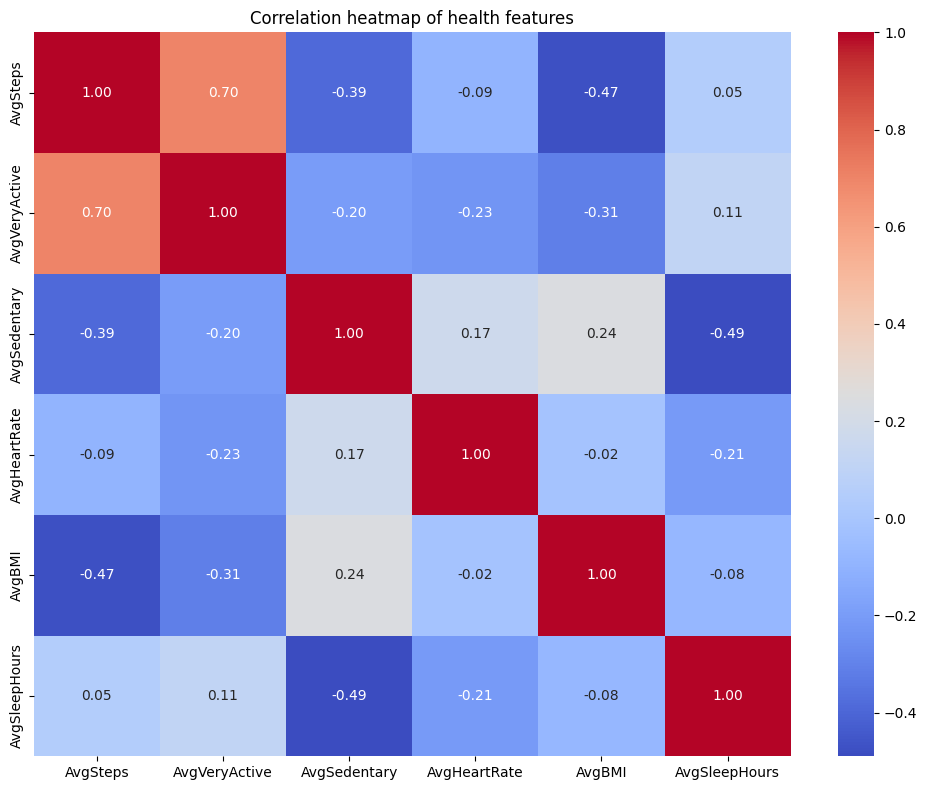

In [14]:
plt.figure(figsize=(10, 8))
corr_combined = pre_final[['AvgSteps','AvgVeryActive','AvgSedentary',
                            'AvgHeartRate','AvgBMI','AvgSleepHours']].corr()
sns.heatmap(corr_combined, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation heatmap of health features')
plt.tight_layout()
plt.show()


We came across the problem of having very few unique users in our data , thats why we used data synthesising techniques to come across limited data constraint

#### Data Agumentation using GaussianCopulaSynthesizer

In [15]:
# Creating metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(pre_final)

# Continuous variables with specific distributions
metadata.update_column('AvgSteps', sdtype='numerical')
metadata.update_column('StdSteps', sdtype='numerical')
metadata.update_column('AvgDistance', sdtype='numerical')
metadata.update_column('AvgCalories', sdtype='numerical')
metadata.update_column('AvgVeryActive', sdtype='numerical')
metadata.update_column('AvgFairlyActive', sdtype='numerical')
metadata.update_column('AvgLightlyActive', sdtype='numerical')
metadata.update_column('AvgSedentary', sdtype='numerical')
metadata.update_column('AvgHeartRate', sdtype='numerical')
metadata.update_column('AvgSleepHours', sdtype='numerical')
metadata.update_column('AvgBMI', sdtype='numerical')

# Setting up UserId as primary key
metadata.set_primary_key('UserId')


In [16]:
synthesizer = GaussianCopulaSynthesizer(
    metadata=metadata,
    enforce_min_max_values=True,  # Keep realistic ranges
    enforce_rounding=False,  # Allow decimal precision
    numerical_distributions={
        'AvgSteps': 'gamma',  # Right-skewed (most people low, some very high)
        'StdSteps': 'gamma',  # Right-skewed (most people low, some very high)
        'AvgHeartRate': 'norm',  # Normal distribution
        'AvgSleepHours': 'norm',  # Normal distribution
        'AvgBMI': 'beta',  # Bounded distribution (18-45)
        'AvgCalories': 'gamma',  # Right-skewed
        'AvgVeryActive': 'gamma',  # Right-skewed (most low, some very active)
    },
    default_distribution='norm'  # Default for others
)
synthesizer.fit(pre_final)
TARGET_SAMPLES = 1000
synthetic_data = synthesizer.sample(num_rows=TARGET_SAMPLES)
synthetic_data

,UserId,AvgSteps,StdSteps,AvgDistance,AvgCalories,AvgVeryActive,AvgFairlyActive,AvgLightlyActive,AvgSedentary,AvgHeartRate,AvgBMI,AvgSleepHours
0,15293993,10902.100942,3959.515553,7.290567,1807.056305,20.762606,26.279789,273.349663,749.734709,74.749349,23.682862,6.071722
1,9902373,916.129032,1469.241786,0.634516,2039.334776,0.474985,0.258065,105.912712,1317.419355,80.927585,30.754387,4.468604
2,11541194,3432.980211,2056.937735,2.188612,1542.178886,0.109668,0.258065,305.200895,1211.146176,87.714164,32.332856,4.993831
3,10394555,10743.504598,3289.952387,8.088205,3436.580645,45.882526,25.262921,121.024492,1101.995965,75.202369,22.657597,5.337500
4,593183,7221.366135,3172.888174,5.142186,2173.678495,2.120907,7.233471,228.925659,1068.190576,83.294193,27.482680,5.363814
...,...,...,...,...,...,...,...,...,...,...,...,...
995,14263328,16040.032258,5908.792683,13.212903,2785.556874,73.981610,18.598496,317.882804,870.288293,79.019373,22.102117,4.890516
996,16450857,12103.611726,4678.319587,9.006493,3436.580645,43.763060,16.807237,178.850051,1013.111900,72.988484,23.598956,5.156347
997,9353345,11237.403690,4390.718215,7.627138,2382.517062,21.660398,10.509309,312.762276,662.322581,57.792231,26.764708,7.103867
998,9827865,9301.893282,3778.601165,7.790697,3298.991060,14.795064,8.395932,219.124293,1179.080274,76.071255,33.186496,5.730579


In [17]:
df_combined = pd.concat([pre_final, synthetic_data], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
df_combined['UserId'] = 'P' + (df_combined.index + 1).astype(str)
int_cols = [
    'AvgSteps', 'StdSteps', 'AvgCalories', 'AvgHeartRate',
]
round_cols = ['AvgDistance', 'AvgBMI', 'AvgSleepHours','AvgSedentary','AvgVeryActive', 'AvgFairlyActive','AvgLightlyActive']
df_combined[int_cols] = df_combined[int_cols].round(0).astype(int)
df_combined[round_cols] = df_combined[round_cols].round(2)
df_combined

,UserId,AvgSteps,StdSteps,AvgDistance,AvgCalories,AvgVeryActive,AvgFairlyActive,AvgLightlyActive,AvgSedentary,AvgHeartRate,AvgBMI,AvgSleepHours
0,P1,6870,4155,4.16,2055,18.06,20.47,221.88,1209.77,82,21.58,4.01
1,P2,8177,5147,6.52,2488,9.88,36.62,60.36,819.13,82,32.10,8.65
2,P3,4115,1826,2.54,2088,3.23,17.37,147.88,779.69,61,26.33,6.78
3,P4,6031,3342,4.35,1989,2.97,5.72,167.78,1029.65,72,26.06,3.08
4,P5,6016,1409,3.88,1875,1.75,20.34,161.31,918.60,58,28.10,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
1028,P1029,4761,1586,2.54,1580,1.73,22.66,174.71,925.98,56,29.86,9.61
1029,P1030,5375,3311,3.08,1496,0.71,2.03,240.19,1032.85,75,27.40,7.67
1030,P1031,3429,3121,1.96,1606,1.11,11.31,174.22,1029.71,79,26.17,7.22
1031,P1032,5408,2226,3.43,1869,5.26,17.63,151.85,863.95,75,33.67,8.46


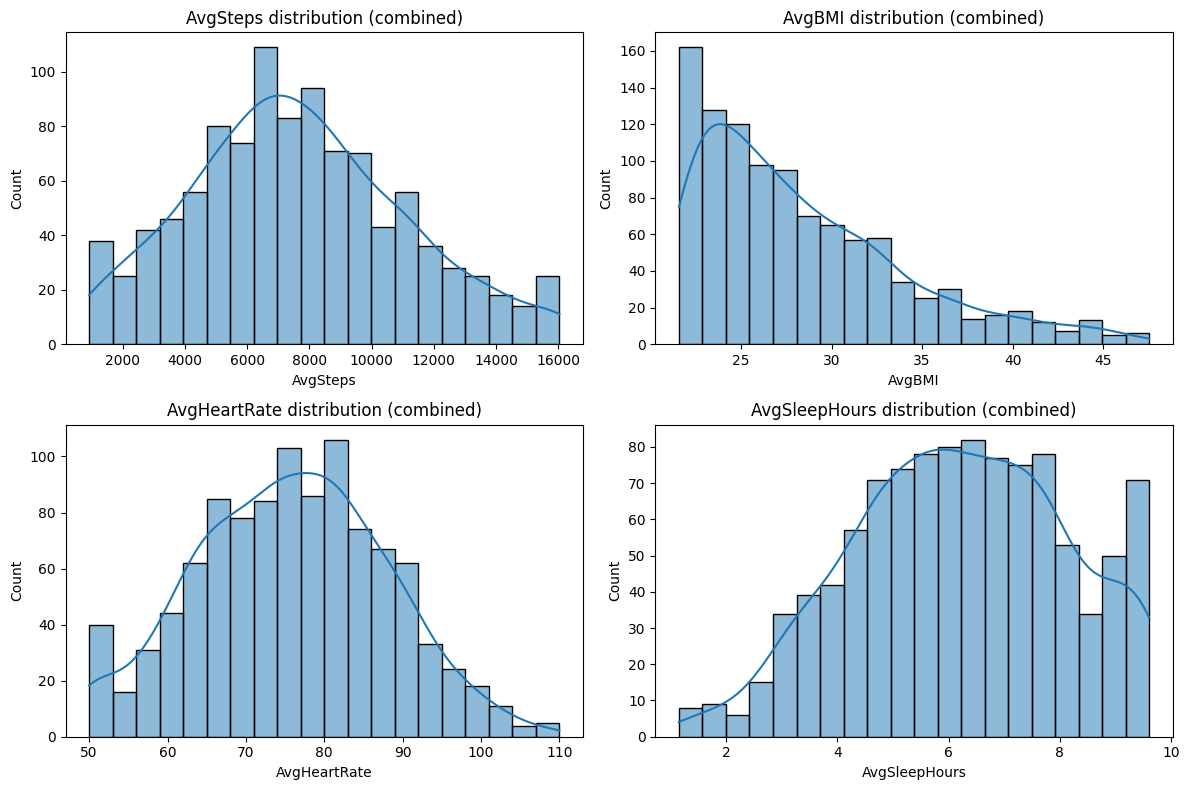

In [18]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(eda_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_combined[col], kde=True, bins=20)
    plt.title(f'{col} distribution (combined)')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


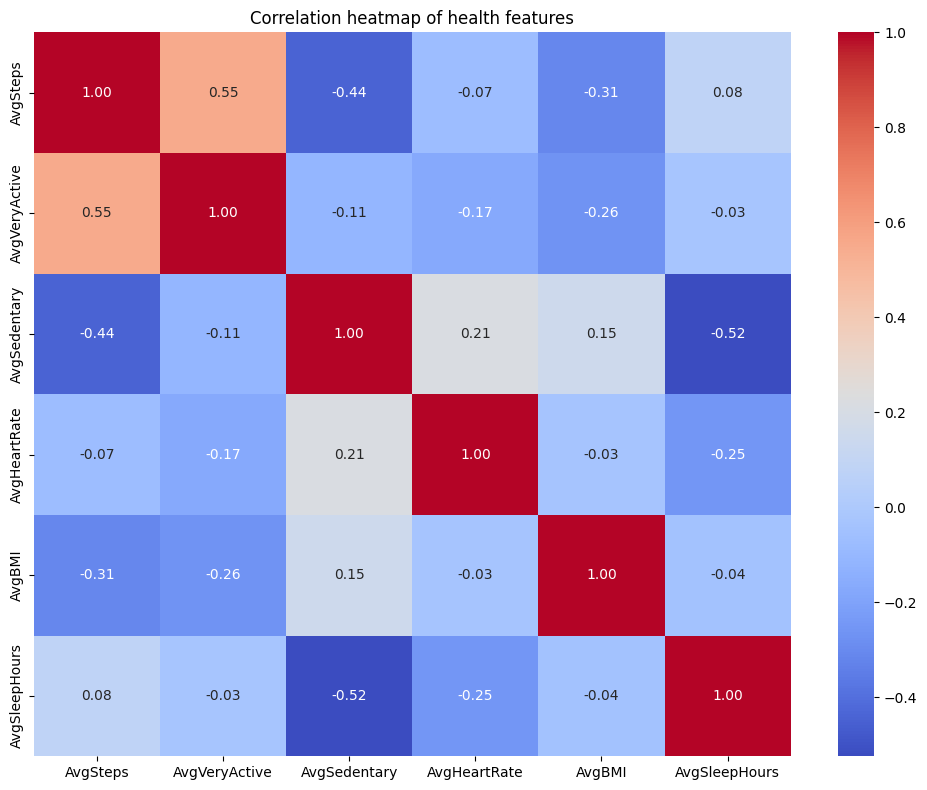

In [19]:
plt.figure(figsize=(10, 8))
corr = df_combined[['AvgSteps','AvgVeryActive','AvgSedentary',
                 'AvgHeartRate','AvgBMI','AvgSleepHours']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation heatmap of health features')
plt.tight_layout()
plt.show()


Relation between AvgSteps and AvgVeryActive

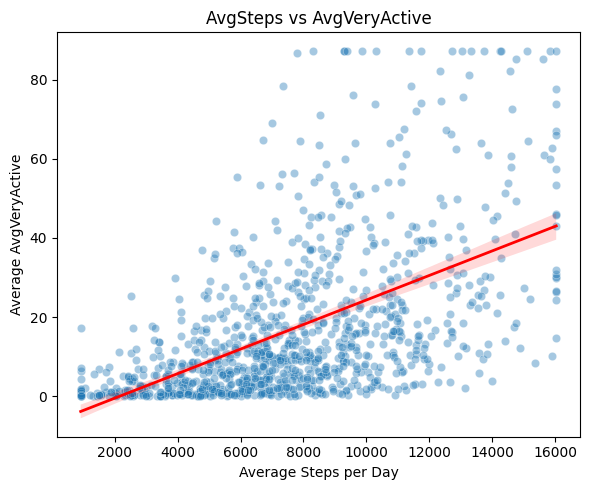

In [20]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_combined, x='AvgSteps', y='AvgVeryActive', alpha=0.4)
sns.regplot(data=df_combined, x='AvgSteps', y='AvgVeryActive',
            scatter=False, color='red', line_kws={'linewidth': 2})
plt.title('AvgSteps vs AvgVeryActive')
plt.xlabel('Average Steps per Day')
plt.ylabel('Average AvgVeryActive')
plt.tight_layout()
plt.show()


#### For Childern , Gender , Smoking , Age

In [21]:
np.random.seed(42)

def assign_age_from_activity(row):
    """
    Assign age based on activity level
    Research: Physical activity declines with age
    - High activity → likely younger (25-40)
    - Moderate activity → middle-aged (35-55)
    - Low activity → older OR very young (40-65 or 18-25)
    """
    steps = row['AvgSteps']
    very_active = row['AvgVeryActive']
    
    if steps > 12000 and very_active > 40:
        # Very active: likely younger athletes or fitness enthusiasts
        age = int(np.random.normal(32, 8))  # Mean 32, std 8
        age = np.clip(age, 22, 45)
    
    elif steps > 8000 and very_active > 20:
        # Moderately active: middle-aged maintaining health
        age = int(np.random.normal(42, 10))  # Mean 42, std 10
        age = np.clip(age, 30, 60)
    
    elif steps > 5000:
        # Lightly active: older adults or busy professionals
        age = int(np.random.normal(48, 12))  # Mean 48, std 12
        age = np.clip(age, 30, 65)
    
    else:
        # Sedentary: either very young (lazy) or elderly
        dice = np.random.random()
        if dice < 0.3:
            # 30% chance: young sedentary (18-25)
            age = int(np.random.normal(22, 3))
            age = np.clip(age, 18, 28)
        else:
            # 70% chance: older sedentary (50-70)
            age = int(np.random.normal(58, 8))
            age = np.clip(age, 45, 70)
    
    return age

df_combined['Age'] = df_combined.apply(assign_age_from_activity, axis=1)

In [22]:
def assign_sex_from_activity(row):
    """
    Assign sex based on activity patterns
    Research: Men do more intense exercise, women more moderate activity
    """
    very_active = row['AvgVeryActive']
    fairly_active = row['AvgFairlyActive']
    
    if very_active > 40:
        # High intensity: 60% male, 40% female
        return np.random.choice(['Male', 'Female'], p=[0.60, 0.40])
    
    elif fairly_active > 30:
        # Moderate intensity: 50-50 split
        return np.random.choice(['Male', 'Female'], p=[0.50, 0.50])
    
    else:
        # Low intensity: slightly more female (light activity preference)
        return np.random.choice(['Male', 'Female'], p=[0.45, 0.55])

df_combined['Sex'] = df_combined.apply(assign_sex_from_activity, axis=1)


In [23]:
def assign_smoker_from_health(row):
    """
    Assign smoking status based on health metrics
    Research: Smokers have:
    - Higher resting heart rate
    - Lower activity levels
    - Higher BMI (on average)
    - Worse sleep quality
    
    Base smoking rate: ~20% in general population
    But varies by health profile
    """
    steps = row['AvgSteps']
    hr = row['AvgHeartRate']
    bmi = row['AvgBMI']
    sleep = row['AvgSleepHours']
    age = row['Age']
    
    # Calculate smoking probability based on health factors
    base_prob = 0.20  # 20% baseline
    
    # Factor 1: Activity level (inverse relationship)
    if steps > 12000:
        activity_factor = 0.3  # Very active: low smoking rate (6%)
    elif steps > 8000:
        activity_factor = 0.6  # Moderately active: 12%
    elif steps > 5000:
        activity_factor = 1.0  # Average: 20%
    else:
        activity_factor = 1.8  # Sedentary: 36%
    
    # Factor 2: Heart rate (smokers have higher HR)
    if hr > 85:
        hr_factor = 1.4  # High HR: more likely smoker
    elif hr > 75:
        hr_factor = 1.2
    elif hr > 65:
        hr_factor = 1.0
    else:
        hr_factor = 0.6  # Low HR: less likely smoker
    
    # Factor 3: BMI (slight positive correlation)
    if bmi > 30:
        bmi_factor = 1.3
    elif bmi > 25:
        bmi_factor = 1.1
    else:
        bmi_factor = 0.9
    
    # Factor 4: Age (peaks at 45-54)
    if 45 <= age <= 54:
        age_factor = 1.2
    elif age < 25 or age > 64:
        age_factor = 0.7
    else:
        age_factor = 1.0
    
    # Factor 5: Sleep (smokers have worse sleep)
    if sleep < 6:
        sleep_factor = 1.3
    elif sleep < 7:
        sleep_factor = 1.1
    else:
        sleep_factor = 0.9
    
    # Calculate final probability
    smoking_prob = base_prob * activity_factor * hr_factor * bmi_factor * age_factor * sleep_factor
    smoking_prob = np.clip(smoking_prob, 0.05, 0.60)  # Keep between 5-60%
    
    # Assign based on probability
    return np.random.choice(['Non-Smoker', 'Smoker'], p=[1-smoking_prob, smoking_prob])

df_combined['Smoker'] = df_combined.apply(assign_smoker_from_health, axis=1)

In [24]:
def assign_children_from_profile(row):
    """
    Assign number of children based on age and activity
    Research: 
    - Older people more likely to have children
    - Parents (especially mothers) have less time for intense exercise
    - Young children = less sleep for parents
    """
    age = row['Age']
    sleep = row['AvgSleepHours']
    very_active = row['AvgVeryActive']
    
    # Base distribution by age
    if age < 25:
        # Young: mostly no children
        children_probs = [0.80, 0.15, 0.04, 0.01, 0.00]  # 0,1,2,3,4+
    
    elif age < 30:
        # Young adults: some starting families
        children_probs = [0.60, 0.25, 0.12, 0.03, 0.00]
    
    elif age < 35:
        # Early 30s: many young families
        children_probs = [0.35, 0.35, 0.22, 0.07, 0.01]
    
    elif age < 45:
        # 35-45: peak family years
        children_probs = [0.20, 0.25, 0.35, 0.15, 0.05]
    
    elif age < 55:
        # 45-55: children might be grown, but had them
        children_probs = [0.25, 0.20, 0.30, 0.20, 0.05]
    
    else:
        # 55+: children grown, or never had
        children_probs = [0.35, 0.20, 0.25, 0.15, 0.05]
    
    # Adjust based on sleep (young children = less sleep)
    if sleep < 6 and 25 <= age <= 40:
        # Poor sleep in family years suggests young children
        # Shift probability toward 1-2 children
        children_probs = [0.15, 0.35, 0.35, 0.12, 0.03]
    
    # Adjust based on very active minutes
    if very_active > 50 and 30 <= age <= 45:
        # High activity in family years suggests fewer/no children (more time)
        # Shift toward fewer children
        children_probs[0] *= 1.5  # More childless
        children_probs[3] *= 0.5  # Fewer 3+
        # Renormalize
        total = sum(children_probs)
        children_probs = [p/total for p in children_probs]
    
    # Sample number of children
    num_children = np.random.choice([0, 1, 2, 3, 4], p=children_probs)
    
    return num_children
df_combined['Children'] = df_combined.apply(assign_children_from_profile, axis=1)

#### Data Check

In [25]:
df_combined

,UserId,AvgSteps,StdSteps,AvgDistance,AvgCalories,AvgVeryActive,AvgFairlyActive,AvgLightlyActive,AvgSedentary,AvgHeartRate,AvgBMI,AvgSleepHours,Age,Sex,Smoker,Children
0,P1,6870,4155,4.16,2055,18.06,20.47,221.88,1209.77,82,21.58,4.01,53,Female,Non-Smoker,3
1,P2,8177,5147,6.52,2488,9.88,36.62,60.36,819.13,82,32.10,8.65,46,Female,Non-Smoker,0
2,P3,4115,1826,2.54,2088,3.23,17.37,147.88,779.69,61,26.33,6.78,49,Male,Smoker,2
3,P4,6031,3342,4.35,1989,2.97,5.72,167.78,1029.65,72,26.06,3.08,51,Male,Non-Smoker,1
4,P5,6016,1409,3.88,1875,1.75,20.34,161.31,918.60,58,28.10,7.98,51,Female,Non-Smoker,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,P1029,4761,1586,2.54,1580,1.73,22.66,174.71,925.98,56,29.86,9.61,62,Male,Non-Smoker,2
1029,P1030,5375,3311,3.08,1496,0.71,2.03,240.19,1032.85,75,27.40,7.67,39,Male,Non-Smoker,0
1030,P1031,3429,3121,1.96,1606,1.11,11.31,174.22,1029.71,79,26.17,7.22,56,Female,Smoker,1
1031,P1032,5408,2226,3.43,1869,5.26,17.63,151.85,863.95,75,33.67,8.46,46,Male,Non-Smoker,3


#### For Risk Factor

In [26]:
def rf_steps(steps):
    # Steps 12k+ = lowest risk; <3k = highest (BMJ, 2022; Munich Re 2018)
    return min(1, max(0, (12000 - steps) / 9000))

def rf_activity(very_active_mins):
    # ≥30 min/day moderate/vigorous = lowest risk, <5 = highest (WHO 2020, BMJ 2022)
    return min(1, max(0, (30 - very_active_mins) / 25))

def rf_rhr(hr):
    # <65 bpm best; >90 bpm worst (CVD risk doubles above 90, [BMJ 2017][Munich Re])
    return min(1, max(0, (hr - 65) / 25))

def rf_sleep(hours):
    # U-shaped, lowest risk at 7-8h, >10 and <5 = highest (meta-analysis, BMJ 2019)
    return min(1, ((abs(hours - 7.5)) / 2.5)**2)

def rf_bmi(bmi):
    # 19-24 ideal; <18 or >30 = substantial risk (WHO, Munich Re, life insurance models)
    if bmi < 19:
        return min(1, (19 - bmi)/3)
    elif bmi <= 24:
        return 0
    elif bmi < 30:
        return (bmi - 24)/6 * 0.5
    else:
        return min(1, 0.5 + (bmi - 30)/15 * 0.5)

def rf_sedentary(minutes):
    # <7h/day (<420min) best; 10h+ (600min) = worst (BMJ 2019; PA meta-analysis)
    return min(1, max(0, (minutes - 420) / 180))

def age_multiplier(age):
    # Insurance multiplier by decade, BMJ 2019/industry default
    if age < 40: return 1.0
    elif age < 50: return 1.2
    elif age < 60: return 1.5
    else: return 2.0

def smoking_multiplier(smoker):
    # CDC, WHO: Risk doubles for smokers (up to 2x normalized)
    if str(smoker).strip().lower() == 'smoker': return 2.0
    else: return 1.0

def sex_multiplier(sex):
    # Males higher risk (CVD, life insurance) by ~10% (industry average)
    if str(sex).strip().lower() == 'male': return 1.1
    else: return 1.0

def calc_scores(row):
    rf_vals = [
        rf_steps(row['AvgSteps']),
        rf_activity(row['AvgVeryActive']),
        rf_rhr(row['AvgHeartRate']),
        rf_sleep(row['AvgSleepHours']),
        rf_bmi(row['AvgBMI']),
        rf_sedentary(row['AvgSedentary'])
    ]
    rf_valid = [v for v in rf_vals if not pd.isna(v)]
    base_health_risk = 100 * np.mean(rf_valid) if rf_valid else np.nan

    # Multipliers
    age_mult = age_multiplier(row['Age'])
    smoking_mult = smoking_multiplier(row['Smoker'])
    sex_mult = sex_multiplier(row['Sex'])
    final_score = base_health_risk * age_mult * smoking_mult * sex_mult
    return pd.Series({
        'HealthRiskScore': base_health_risk,
        'AgeMultiplier': age_mult,
        'SmokingMultiplier': smoking_mult,
        'SexMultiplier': sex_mult,
        'FinalRiskScore': final_score
    })

In [27]:
results = df_combined.apply(calc_scores, axis=1)
df = pd.concat([df_combined, results['FinalRiskScore']], axis=1)
df

,UserId,AvgSteps,StdSteps,AvgDistance,AvgCalories,AvgVeryActive,AvgFairlyActive,AvgLightlyActive,AvgSedentary,AvgHeartRate,AvgBMI,AvgSleepHours,Age,Sex,Smoker,Children,FinalRiskScore
0,P1,6870,4155,4.16,2055,18.06,20.47,221.88,1209.77,82,21.58,4.01,53,Female,Non-Smoker,3,93.190000
1,P2,8177,5147,6.52,2488,9.88,36.62,60.36,819.13,82,32.10,8.65,46,Female,Non-Smoker,0,73.823556
2,P3,4115,1826,2.54,2088,3.23,17.37,147.88,779.69,61,26.33,6.78,49,Male,Smoker,2,138.741758
3,P4,6031,3342,4.35,1989,2.97,5.72,167.78,1029.65,72,26.06,3.08,51,Male,Non-Smoker,1,113.159444
4,P5,6016,1409,3.88,1875,1.75,20.34,161.31,918.60,58,28.10,7.98,51,Female,Non-Smoker,2,76.085489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,P1029,4761,1586,2.54,1580,1.73,22.66,174.71,925.98,56,29.86,9.61,62,Male,Non-Smoker,2,146.850098
1029,P1030,5375,3311,3.08,1496,0.71,2.03,240.19,1032.85,75,27.40,7.67,39,Male,Non-Smoker,0,62.774588
1030,P1031,3429,3121,1.96,1606,1.11,11.31,174.22,1029.71,79,26.17,7.22,56,Female,Smoker,1,185.285533
1031,P1032,5408,2226,3.43,1869,5.26,17.63,151.85,863.95,75,33.67,8.46,46,Male,Non-Smoker,3,85.620343


### Data description
#### Source: Public Kaggle Fitbit dataset (“Fitabase Data 4.12.16–5.12.16”), accessed via kagglehub.
#### Content: Daily activity, heart rate (seconds), sleep (minutes), and weight/BMI logs for 33 individuals over ~1 month.
#### Processing:
- Aggregated daily logs to user-level metrics:
- AvgSteps, StdSteps, AvgDistance, AvgCalories
- AvgVeryActive, AvgFairlyActive, AvgLightlyActive, AvgSedentary
- AvgHeartRate, AvgBMI, AvgSleepHours
- Imputed missing AvgHeartRate, AvgSleepHours, AvgBMI using science-based rules that reflect known relationships (activity vs HR, sleep vs activity, BMI vs activity).
- Generated 1,000 synthetic users with GaussianCopulaSynthesizer to preserve marginal distributions and correlations, then combined with the 33 real users (total N=1033).

#### Final feature set used for modeling:
- Health: 12 metrics (steps, activity intensities, HR, BMI, sleep, sedentary).
- Demographics (simulated): Age, Sex, Smoker, Children.
- Risk metrics: HealthRiskScore, FinalRiskScore, KMeansCluster, KMeansTier.

In [28]:
# Preparing clustering data
health_cols = ['AvgSteps', 'AvgVeryActive', 'AvgHeartRate', 'AvgSleepHours', 'AvgBMI', 'AvgSedentary']
clustering_data = df[health_cols].copy()

# Standardizing features for fair clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_data)

# Running K-means clustering (K=3 for three tiers)
kmeans = KMeans(n_clusters=3, n_init=50, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assigning cluster labels to dataframe and re-label as tiers
df['KMeansCluster'] = clusters
cluster_risk_means = df.groupby('KMeansCluster')[health_cols + (['FinalRiskScore'] if 'FinalRiskScore' in df.columns else [])].mean()
risk_order = cluster_risk_means.mean(axis=1).index # clusters ordered from healthiest to riskiest
mapping = dict(zip(risk_order, ['Gold (Low)', 'Silver (Medium)', 'Bronze (High)']))
df['KMeansTier'] = df['KMeansCluster'].map(mapping)

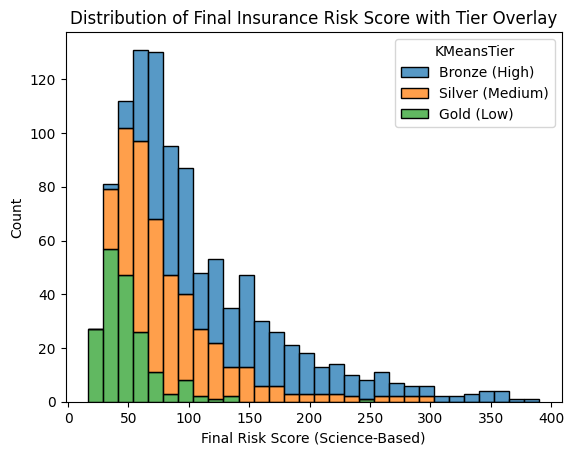

In [29]:
sns.histplot(data=df,x='FinalRiskScore',hue='KMeansTier',bins=30,multiple="stack")
plt.title("Distribution of Final Insurance Risk Score with Tier Overlay")
plt.xlabel("Final Risk Score (Science-Based)")
plt.ylabel("Count")
plt.show()

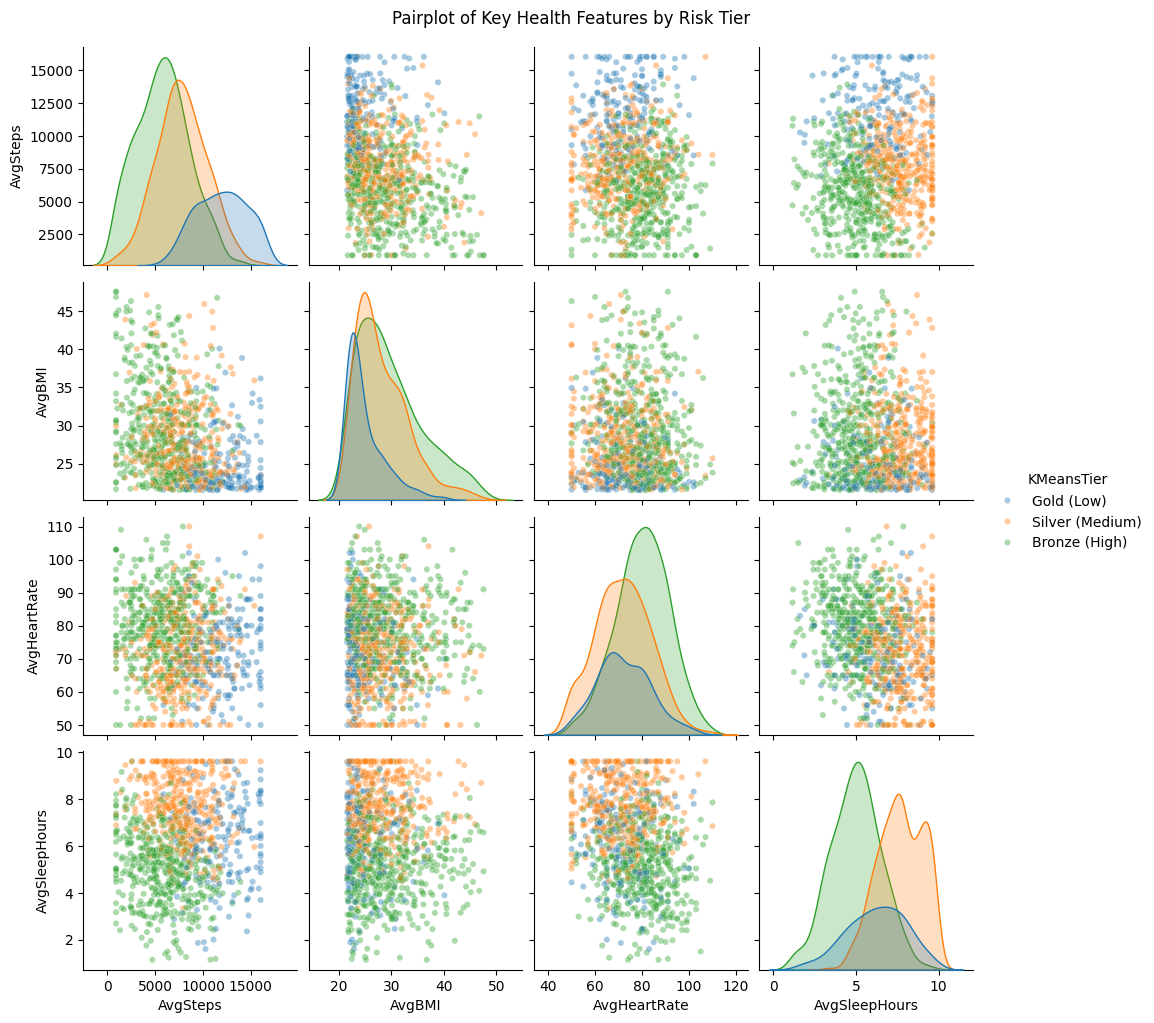

In [30]:
subset_cols = ['AvgSteps', 'AvgBMI', 'AvgHeartRate', 'AvgSleepHours', 'KMeansTier']
sns.pairplot(df[subset_cols], hue='KMeansTier',
             hue_order=['Gold (Low)', 'Silver (Medium)', 'Bronze (High)'],
             diag_kind='kde', plot_kws={'alpha': 0.4, 's': 20})
plt.suptitle('Pairplot of Key Health Features by Risk Tier', y=1.02)
plt.show()


In [31]:
X = df[['AvgSteps','AvgVeryActive','AvgHeartRate','AvgBMI','AvgSleepHours','AvgSedentary','Age']]
y = df['KMeansTier'].map({'Gold (Low)':0, 'Silver (Medium)':1, 'Bronze (High)':2}) # adjust as needed

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy={acc:.3f}, F1_weighted={f1:.3f}")
    

LogReg: Accuracy=0.938, F1_weighted=0.938
RandomForest: Accuracy=0.919, F1_weighted=0.918


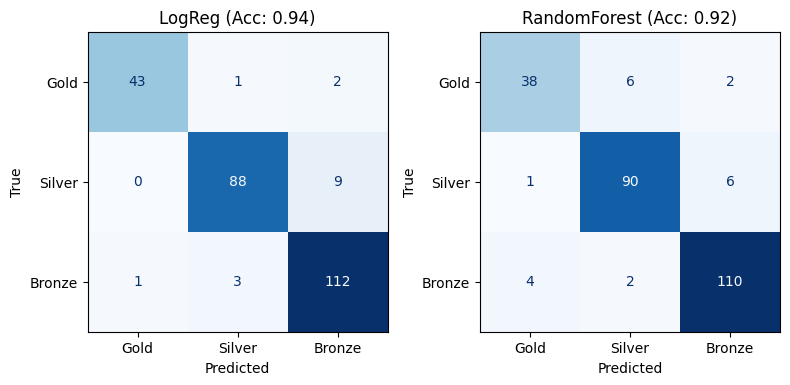

In [32]:
def plot_model_confusions(models, X_test, y_test, class_names=None, figsize_per=4):
    """
    Plotting confusion matrices for a dictionary of trained models.

    Args:
        models (dict): name: sklearn model
        X_test: test features
        y_test: test labels
        class_names (list/None): custom class labels; inferred if None
        figsize_per (int): width per figure for each plot (in inches)
    """
    n_models = len(models)
    ncols = min(n_models, 3)
    nrows = (n_models + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per * ncols, figsize_per * nrows))

    # Support case where axes is 1D, not always 2D array
    axes = axes.flatten() if n_models > 1 else [axes]

    for idx, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=class_names,
            cmap='Blues',
            colorbar=False,
            ax=axes[idx]
        )
        axes[idx].set_title(f"{name} (Acc: {accuracy_score(y_test, y_pred):.2f})")
        axes[idx].set_xlabel("Predicted")
        axes[idx].set_ylabel("True")
    # Hide any extra axes
    for idx in range(len(models), len(axes)):
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

plot_model_confusions(models, X_test, y_test, class_names=['Gold','Silver','Bronze'])

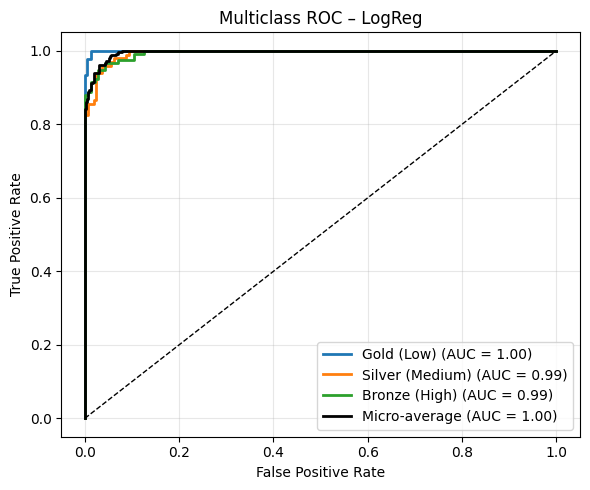

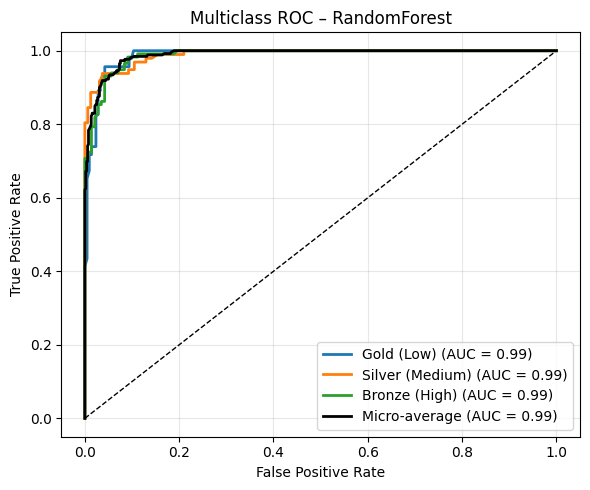

In [33]:
# ROC AUC CURVE


classes = [0, 1, 2] 
y_test_bin = label_binarize(y_test, classes=classes)

for name, model in models.items():
    if not hasattr(model, "predict_proba"):
        continue
    
    y_proba = model.predict_proba(X_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot
    plt.figure(figsize=(6, 5))
    for cls, label in zip(classes, ['Gold (Low)', 'Silver (Medium)', 'Bronze (High)']):
        plt.plot(fpr[cls], tpr[cls], lw=2, label=f"{label} (AUC = {roc_auc[cls]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.plot(fpr["micro"], tpr["micro"], color='black', lw=2,
             label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multiclass ROC – {name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [34]:
# Defining stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n--- 5-Fold Cross-Validation Results ---")
for name, model in models.items():
    acc_cv = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    f1_cv = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
    print(f"{name}: mean Accuracy={acc_cv.mean():.3f} (±{acc_cv.std():.3f}), mean F1_w={f1_cv.mean():.3f} (±{f1_cv.std():.3f})")



--- 5-Fold Cross-Validation Results ---
LogReg: mean Accuracy=0.950 (±0.019), mean F1_w=0.950 (±0.019)
RandomForest: mean Accuracy=0.935 (±0.012), mean F1_w=0.941 (±0.014)


In [35]:
# 1. LOGISTIC REGRESSION - Coefficients (Log-Odds)
print("\n LOGISTIC REGRESSION COEFFICIENTS (Log-Odds)")

lr = models['LogReg']
coef_df = pd.DataFrame(
    lr.coef_.T,
    index=X.columns,
    columns=['Gold_vs_ref', 'Silver_vs_ref', 'Bronze_vs_ref']
).round(4)

print(coef_df)
print("\nInterpretation:")
print("  - Positive coefficient: Higher feature value → higher odds of that tier")
print("  - Negative coefficient: Higher feature value → lower odds of that tier")
print("  - Magnitude shows strength of association\n")

# 2. RANDOM FOREST - Feature Importances
print("RANDOM FOREST FEATURE IMPORTANCES")

rf = models['RandomForest']
fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print(fi_df)
print("\nInterpretation:")
print("  - Higher importance = feature is more influential in tree splits")
print("  - Sum of all importances = 1.0")




 LOGISTIC REGRESSION COEFFICIENTS (Log-Odds)
               Gold_vs_ref  Silver_vs_ref  Bronze_vs_ref
AvgSteps            0.0019        -0.0005        -0.0014
AvgVeryActive       0.4422        -0.2069        -0.2353
AvgHeartRate       -0.1023         0.0042         0.0981
AvgBMI             -0.5987         0.3041         0.2946
AvgSleepHours      -0.3181         1.5797        -1.2616
AvgSedentary       -0.0074        -0.0063         0.0136
Age                 0.0270         0.0122        -0.0392

Interpretation:
  - Positive coefficient: Higher feature value → higher odds of that tier
  - Negative coefficient: Higher feature value → lower odds of that tier
  - Magnitude shows strength of association

RANDOM FOREST FEATURE IMPORTANCES
         Feature  Importance
0   AvgSedentary    0.292320
1  AvgVeryActive    0.248533
2  AvgSleepHours    0.198202
3       AvgSteps    0.131242
4   AvgHeartRate    0.051423
5         AvgBMI    0.048297
6            Age    0.029983

Interpretation:
  - Hi

# Error analysis & insights
#### Confusion matrices show that:
- Most errors occur between Bronze and Silver tiers, which is expected because medium- and high-risk users can have overlapping metric ranges (e.g., borderline steps or BMI).

Gold (Low) tier is relatively well separated, with fewer misclassifications into Bronze. This aligns with its more extreme values (high steps, good HR, good BMI, good sleep, good sedentary time).

Feature importance and logistic regression coefficients suggest that:
- AvgBMI, AvgHeartRate and AvgSedentary are the strongest drivers of moving users into higher-risk tiers.
- AvgSteps and AvgVeryActive act protectively, pushing users towards Gold/Silver tiers.

Interpretation:
- The model is strongest at identifying clearly healthy and clearly unhealthy profiles.
- The model struggles most on “borderline” users with mid-range BMI, moderate steps, and moderate sleep, which is realistic for clinical and insurance risk stratification tasks.

In [ ]:
# Feature names in order used for training
feature_names = ['AvgSteps', 'AvgVeryActive', 'AvgHeartRate',
                 'AvgBMI', 'AvgSleepHours', 'AvgSedentary', 'Age']

# Compute min/max from the final dataset
feature_min = df[feature_names].min()
feature_max = df[feature_names].max()

# Collect user input (must be within min/max)
user_values = []
print("Enter your health metrics:")
for fname in feature_names:
    fmin = feature_min[fname]
    fmax = feature_max[fname]
    prompt = f"{fname} [min={fmin:.2f}, max={fmax:.2f}]: "

    while True:
        try:
            val = float(input(prompt))
            if val < fmin or val > fmax:
                print(f"  Value must be between {fmin:.2f} and {fmax:.2f}. Please try again.")
                continue
            user_values.append(val)
            break
        except ValueError:
            print("  Invalid input, please enter a number.")

# Create a single-row DataFrame for prediction
user_X = pd.DataFrame([user_values], columns=feature_names)

# Predict with each model
tier_mapping = {0: 'Gold (Low)', 1: 'Silver (Medium)', 2: 'Bronze (High)'}

print("\nYour input:")
for name, val in zip(feature_names, user_values):
    print(f"  {name:15s} = {val:.2f}  (allowed range: {feature_min[name]:.2f}–{feature_max[name]:.2f})")

print("\nModel predictions:")
predicted_tiers = []

for name, model in models.items():
    pred = model.predict(user_X)[0]          # numeric code
    tier = tier_mapping.get(pred, pred)      # mapped label
    predicted_tiers.append(tier)
    print(f"  {name:12s} → {tier}")

# Consensus & recommendations
if len(set(predicted_tiers)) == 1:
    consensus_tier = predicted_tiers[0]
else:
    consensus_tier = 'Mixed'

print("\nConsensus tier:", consensus_tier)

if 'Gold' in consensus_tier:
    print("""
Excellent Health Profile!
- Continue maintaining your current activity levels
- Keep regular sleep schedule (7-8 hours)
- Monitor BMI and heart rate periodically
- Consider preventive health screenings
    """)
elif 'Silver' in consensus_tier:
    print("""
Moderate Health Risk
- Increase daily steps (target: 10,000+)
- Add 30+ minutes of vigorous activity
- Improve sleep quality (aim for 7-8 hours)
- Consider reducing sedentary time
- Schedule health check-up
    """)
elif 'Bronze' in consensus_tier:
    print("""
Higher Health Risk Detected
- Urgent: Consult healthcare provider
- Start gradual activity increase (walk 15-30 min daily)
- Address sleep issues (seek medical advice if <6 hours)
- Monitor heart rate and BMI closely
- Consider smoking cessation if applicable
- Reduce sedentary time significantly
    """)
else:
    print("""
📊 Mixed Predictions - Borderline Risk Profile
- Consult healthcare provider for personalized assessment
- Focus on improving key metrics (steps, activity, sleep)
- Regular monitoring recommended
    """)


# Limitations & future work
#### Limitations:
- No true outcome labels: Risk scores and tiers are constructed proxies (based on epidemiology and clustering), not real claims, hospitalization, or mortality data.
- Synthetic demographics: Age, sex, smoker status, and children counts are simulated using statistical rules. They resemble population patterns but do not represent real individuals.
- Small original sample: Only 33 real users; synthetic expansion to 1033 amplifies existing patterns and cannot add genuinely new variation.
- Multicollinearity: Some health features (e.g., AvgHeartRate, AvgBMI, AvgSedentary) exhibit high VIF scores, which can affect linear-model interpretability. Tree models handle this better, but it is still a modeling caveat.
- Cross-sectional: The analysis is based on aggregated averages per user; it does not capture temporal changes or trajectories in health behavior.

#### Future work:
- Acquire and link real outcome data (claims, diagnoses, events) to validate the constructed risk scores and tiers against actual insurance outcomes.
- Explore longitudinal modeling of daily time-series data (e.g., sequence models) for early detection of risk transitions.
- Add more models (e.g., XGBoost, calibrated models) and compare with external benchmarks.
- Investigate fairness and bias across demographic groups if used in any real-world decision-making context.